In [434]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [435]:
# !pip install lightgbm

### Предобработка

In [436]:
data = pd.read_csv('insurance.csv')

In [437]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [438]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [439]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [441]:
#посмотрим пропуски
print("Количество строк = ", data.shape[0])
print("Количество столбцов = ", data.shape[1])

headers = data.columns
count_null = pd.DataFrame(data[headers].isnull().sum())
count_null = count_null.reset_index()
count_null.rename(columns = {'index' : 'Column', 0 : 'Count_null'}, inplace = True) 
count_null
#пропусков нет

Количество строк =  1338
Количество столбцов =  7


,Column,Count_null
0,age,0
1,sex,0
2,bmi,0
3,children,0
4,smoker,0
5,region,0
6,charges,0


In [442]:
#кодирование категориальных признаков
labelencoder = LabelEncoder()
data['sex'] = labelencoder.fit_transform(data['sex'])
data['smoker'] = labelencoder.fit_transform(data['smoker'])
data['region'] = labelencoder.fit_transform(data['region'])
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


<AxesSubplot:>

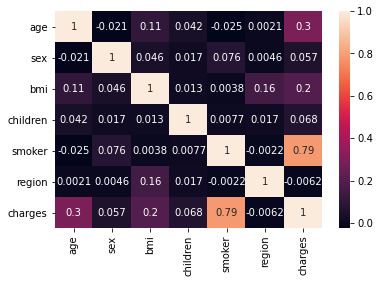

In [443]:
#корреляционная матрица
sns.heatmap(data.corr(), annot=True)

C:\Users\alexe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='charges', ylabel='Density'>

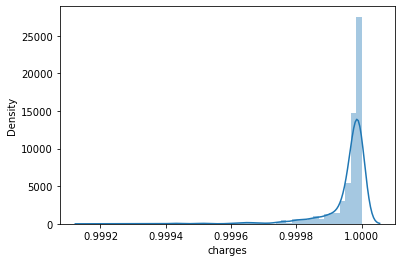

In [489]:
#распределение целевой переменной
sns.distplot(data['charges'])

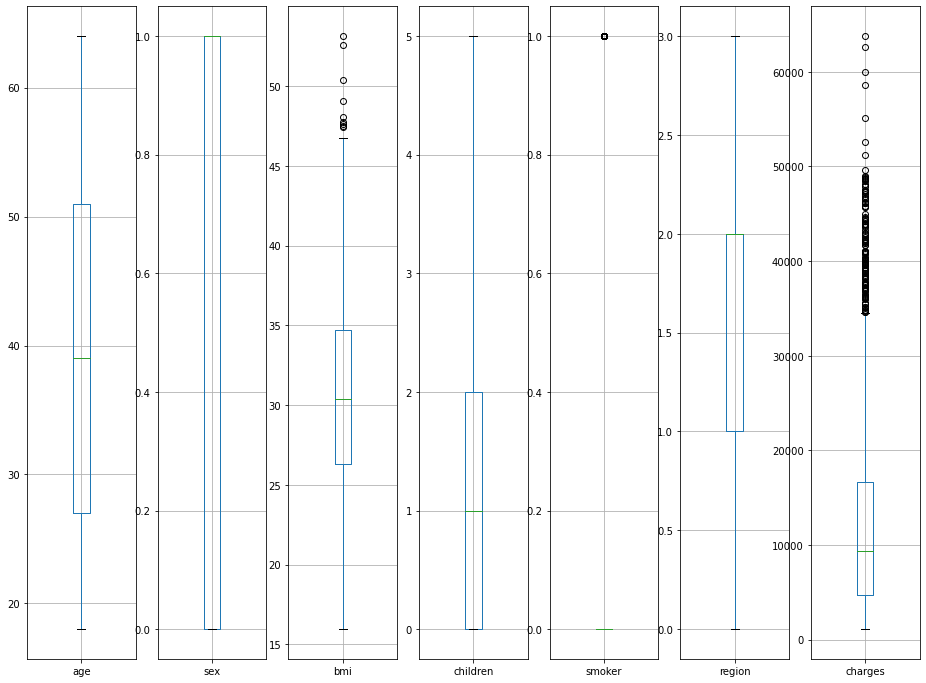

In [444]:
#выбросы
i = 0
fig = plt.figure(figsize=(16, 12))
for column in data.columns:
    ax = fig.add_subplot(1, 7, i + 1)
    data.boxplot(column=[column])
    i += 1

In [445]:
#посмотрим выброси по признаку bmi и charges
suspicious_column = ['bmi']

for column in suspicious_column:
    for x in [column]:
        q75,q25 = np.percentile(data.loc[:,x],[75,25])
        intr_qr = q75-q25

        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)
        
        print('Column = ', column, '; Count_value (< min) = ', data.loc[data[x] < min,x].shape[0])
        data.loc[data[x] < min,x] = np.nan
        print('Column = ', column, '; Count_value (> max) = ', data.loc[data[x] > max,x].shape[0])
        data.loc[data[x] > max,x] = np.nan

Column =  bmi ; Count_value (< min) =  0
Column =  bmi ; Count_value (> max) =  9


In [446]:
data = data.dropna() #удалили выбросы

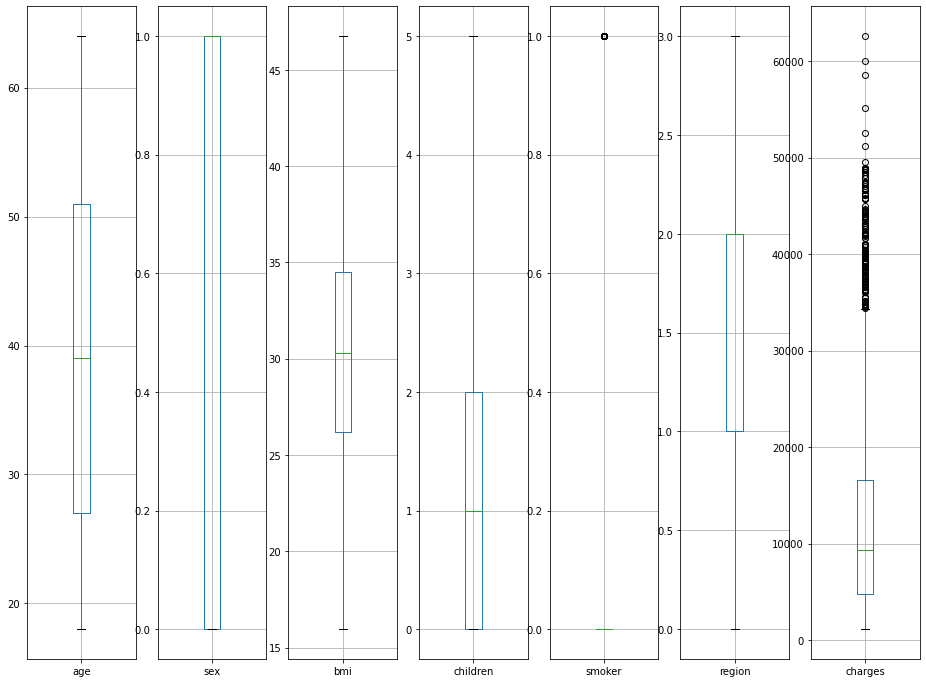

In [447]:
#выбросы
i = 0
fig = plt.figure(figsize=(16, 12))
for column in data.columns:
    ax = fig.add_subplot(1, 7, i + 1)
    data.boxplot(column=[column])
    i += 1

In [448]:
#нормализуем данные
data_columns = ['age', 'bmi', 'children', 'charges']
data[data_columns] = pd.DataFrame(preprocessing.normalize(data[data_columns]), columns=data_columns)

In [449]:
data = data.dropna()

## Обучение

In [450]:
X = data.iloc[:, :5]
y = data.iloc[:, -1]

In [451]:
#разбили выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Линейная регрессия

In [452]:
#линейная регрессия
lr = LinearRegression().fit(X_train, y_train)
score_lr = lr.score(X_test, y_test)
score_lr

0.9116615581491786

### Деревья решений

In [453]:
#деревья решений
max_depth = np.arange(1, 30, 1)
score = []

for d in max_depth:
    dtr = DecisionTreeRegressor(max_depth=d)
    dtr.fit(X_train, y_train)
    score.append(dtr.score(X_test, y_test))

0.9970791140245181
12


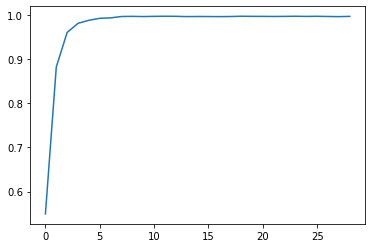

In [454]:
plt.plot(score)
print(np.amax(score))
print(np.argmax(score) + 1)

#лучшая глубина - 18

In [455]:
min_samples_leaf = np.arange(1, 100, 1)
score = []

for s in min_samples_leaf:
    dtr = DecisionTreeRegressor(max_depth=18, min_samples_leaf=s)
    dtr.fit(X_train, y_train)
    score.append(dtr.score(X_test, y_test))

0.9965200106500209
1


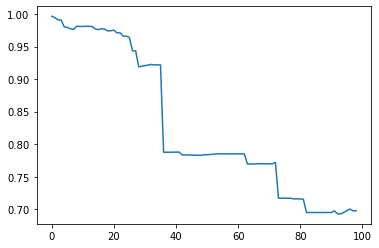

In [456]:
plt.plot(score)
score_dtr = np.amax(score)
print(np.amax(score))
print(np.argmax(score) + 1)

#min_samples_leaf - 1

In [457]:
# min_samples_split = np.arange(2, 100, 1)
# score = []
# for s in min_samples_split:
#     dtr = DecisionTreeRegressor(max_depth=4, min_samples_leaf=45, min_samples_split=s)
#     dtr.fit(X_train, y_train)
#     score.append(dtr.score(X_test, y_test))

In [458]:
# plt.plot(score)
# print(np.amax(score))
# print(np.argmax(score) + 1)

# #min_samples_split - 

### Случайный лес

In [459]:
max_depth = np.arange(1, 30, 1)
score = []
for d in max_depth:
    rf = RandomForestRegressor(max_depth=d)
    rf.fit(X_train, y_train)
    score.append(rf.score(X_test, y_test))

0.998072329768577
29


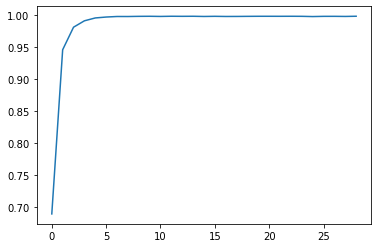

In [460]:
plt.plot(score)
score_rf = np.amax(score)
print(np.amax(score))
print(np.argmax(score) + 1)

In [461]:
#score
#лучшая глубина - 13

In [462]:
min_samples_leaf = np.arange(1, 100, 1)
score = []
for s in min_samples_leaf:
    rf = RandomForestRegressor(max_depth=13, min_samples_leaf=s)
    rf.fit(X_train, y_train)
    score.append(rf.score(X_test, y_test))

0.9976771548705946
1


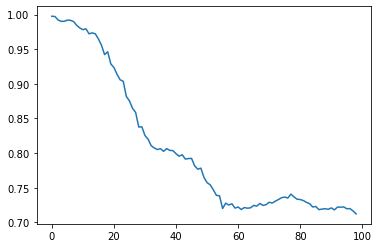

In [463]:
plt.plot(score)
print(np.amax(score))
print(np.argmax(score) + 1)

#min_samples_leaf=1

In [464]:
min_samples_split = np.arange(2, 100, 1)
score = []
for s in min_samples_split:
    rf = RandomForestRegressor(max_depth=13, min_samples_leaf=1, min_samples_split=s)
    rf.fit(X_train, y_train)
    score.append(rf.score(X_test, y_test))

0.9982361784306358
3


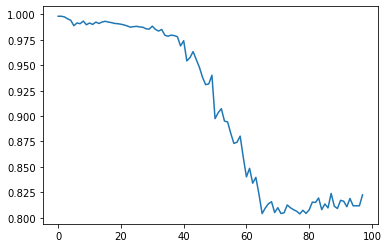

In [465]:
plt.plot(score)
print(np.amax(score))
print(np.argmax(score) + 2)

#min_samples_split = 3

### KNN

In [466]:
# #номализуем данные
# data_columns = ['age', 'bmi', 'children', 'charges']
# data_knn = data.copy()
# data_knn[data_columns] = pd.DataFrame(preprocessing.normalize(data[data_columns]), columns=data_columns)

In [467]:
# data_knn = data_knn.dropna()
# X_knn = data_knn.iloc[:, :5]
# y_knn = data_knn.iloc[:, -1]
# #разбили выборку
# Xknn_train, Xknn_test, yknn_train, yknn_test = train_test_split(X_knn, y_knn, test_size=0.20)

In [468]:
n_neighbors = np.arange(1, 50, 1)
score = []
for n in n_neighbors:
    knr = KNeighborsRegressor(n_neighbors=n)
    knr.fit(X_train, y_train)
    score.append(knr.score(X_test, y_test))

0.9967139380425645
2


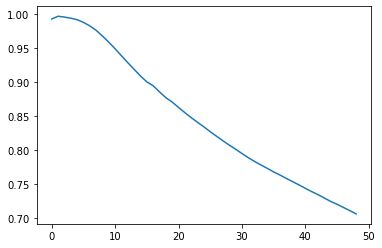

In [469]:
plt.plot(score)
score_knr = np.amax(score)
print(np.amax(score))
print(np.argmax(score) + 1)

#n_neighbors=1

### Сравнение

In [470]:
d = {"Score":[score_knr, score_dtr, score_rf, score_lr]}
df2 = pd.DataFrame(d, index=['KNeighborsRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor', 'LinearRegression'])

# Ансамбли

In [471]:
lr = LinearRegression().fit(X_train, y_train)
dtr = DecisionTreeRegressor(max_depth=18, min_samples_leaf=1)
rf = RandomForestRegressor(max_depth=13)
knr = KNeighborsRegressor(n_neighbors=18)

### Стеккинг

In [472]:
from itertools import permutations

In [473]:
best = []
best_score = 0
est = [lr, dtr, rf, knr]
permut = list(permutations(est))
print(len(permut))

for p in permut:
    estimators = [('e1', p[0]), ('e2', p[1]), ('e3', p[2])]
    clf_stacking = StackingRegressor(estimators=estimators, final_estimator=p[3])
    clf_stacking.fit(X_train, y_train)
    score = clf_stacking.score(X_test, y_test)
    if score > best_score:
        best = p
        best_score = score
    print(score)

24
0.9794564461725159
0.9966416331900527
0.979624097086896
0.9967497339044433
0.9957480403266221
0.9973681441317596
0.9794161913983279
0.9959234682910295
0.9793406888051835
0.997493166997268
0.9958802097623978
0.9976046753400662
0.9793128993454506
0.997323325119926
0.9794469892053151
0.9976589970192026
0.9959334813668362
0.9975490091189025
0.9961491959477319
0.9952964829211989
0.9958732329734032
0.9979065885831778
0.9970944677343777
0.9973922948505918


In [474]:
print(f"Лучшая комбинация {best} с результатом {best_score}")
score_stacking = best_score

Лучшая комбинация (KNeighborsRegressor(n_neighbors=18), DecisionTreeRegressor(max_depth=18), RandomForestRegressor(max_depth=13), LinearRegression()) с результатом 0.9979065885831778


### Бэггинг

In [475]:
score = []
est = [lr, dtr, rf, knr]
best_score = 0
best_e = []
best_i = []

for e in est:
    for i in range(1, 10):
        clf_bag = BaggingRegressor(base_estimator=e, n_estimators=i, random_state=12)
        clf_bag.fit(X_train, y_train)
        score = clf_bag.score(X_test, y_test)
        if score > best_score:
            best_e = e
            best_i = i
            best_score = score

In [476]:
print(f"Лучшая модель {best_e} в количестве {best_i} с результатом {best_score}")
score_bagging = best_score

Лучшая модель DecisionTreeRegressor(max_depth=18) в количестве 9 с результатом 0.998002289049384


### Бустинг

### адаптивный бустинг

In [477]:
n_est = np.arange(1, 30, 1)
score = []
for n in n_est: 
    clf_adaboost = AdaBoostRegressor(base_estimator=knr, n_estimators=n, random_state=12)
    clf_adaboost.fit(X_train, y_train)
    score.append(clf_adaboost.score(X_test, y_test))

0.9965814603645782
13


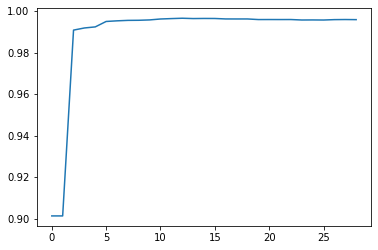

In [478]:
plt.plot(score)
print(np.amax(score))
print(np.argmax(score) + 1)
score_adaboost = np.amax(score)

### Градиентный бустинг

In [479]:
max_depth = np.arange(1, 30, 1)
score = []
for d in max_depth:
    clf_grboost = GradientBoostingRegressor(max_depth=d, n_estimators=100, random_state=12, learning_rate=1)
    clf_grboost.fit(X_train, y_train)
    score.append(clf_grboost.score(X_test, y_test))

0.998244028044048
2


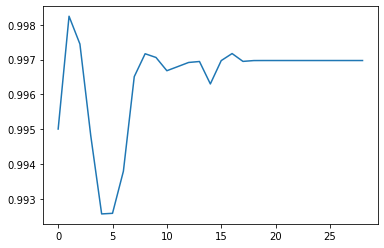

In [480]:
plt.plot(score)
print(np.amax(score))
print(np.argmax(score) + 1)
score_gradboost = np.amax(score)

# Финальное сравнение

In [486]:
d3 = {"Score":[score_knr, score_dtr, score_rf, score_lr, score_stacking, score_bagging, score_adaboost, score_gradboost]}
df3 = pd.DataFrame(d3, index=[ 'KNeighborsRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor'
                            , 'LinearRegression', 'StackingRegressor', 'BaggingRegressor'
                            , 'AdaBoostRegressor', 'GradientBoostingRegressor'])
df3 = df3.sort_values(by='Score', ascending=False)
df3

,Score
GradientBoostingRegressor,0.998244
RandomForestRegressor,0.998072
BaggingRegressor,0.998002
StackingRegressor,0.997907
KNeighborsRegressor,0.996714
AdaBoostRegressor,0.996581
DecisionTreeRegressor,0.996520
LinearRegression,0.911662
